In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from keras import models
from keras.layers import Dense,Conv1D, Reshape,Flatten,Lambda

Using TensorFlow backend.


In [3]:
from keras.optimizers import Adam
from keras import backend as K

In [17]:
class Data:
    def __init__(self, mu, sigma ,ni_D):
        self.real_sample = lambda n_batch : np.random.normal(mu, sigma,(n_batch,ni_D))
        self.in_sample = lambda n_batch : np.random.rand(n_batch,ni_D)
        

In [57]:
class Machine:
    def __init__(self, n_batch= 10 , ni_D = 100):
        data_mean =4
        data_stddev = 1.25
        self.data = Data(data_mean, data_stddev , ni_D)
        self.gan = GAN(ni_D = ni_D, nh_D= 50 ,nh_G =50)
        self.n_batch = n_batch
        self.n_iter_D = 1
        self.n_iter_G =1
    
    def run(self, n_repeat=30000//200 ,n_show =200 , n_test =100):
        for ii in range(n_repeat):
            print('Stage' ,ii ,'(Epoch:{})'.format(ii*n_show))
            self.run_epochs(n_show,n_test)
            plt.show()
    
    def run_epochs(self,epochs,n_test):
        self.train(epochs)
        self.test_and_show(n_test)
        
    def train(self,epochs):
        for epoch in range(epochs):
            self.train_each()
            
    def train_each(self):
        for it in range(self.n_iter_D):
            self.train_D()
        for it in range(self.n_iter_G):
            self.train_GD()
            
    def test(self,n_test):
        gan = self.gan
        data =self.data
        Z= data.in_sample(n_test)
        Gen =gan.G.predict(Z)
        return Gen,Z
            
    def train_D(self):
        gan = self.gan
        n_batch =self.n_batch
        data = self.data
        Real = data.real_sample(n_batch)
        Z = data.in_sample(n_batch)
        Gen = gan.G.predict(Z)
        gan.D.trainable =True
        gan.D_train_on_batch(Real,Gen)
    
    def train_GD(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data
        Z = data.in_sample(n_batch)
        
        gan.D.trainable = False
        gan.GD_train_on_batch(Z)
        
    def test_and_show(self, n_test):
        data = self.data
        Gen , Z =self.test(n_test)
        Real = data.real_sample(n_test)
        self.show_hist(Real,Gen,Z)
        Machine.print_stat(Real,Gen)
    
    def show_hist(self,Real,Gen,Z):
        plt.hist(Real.reshape(-1),histtype ='step',label='Real')
        plt.hist(Gen.reshape(-1),histtype='step',label='Generated')
        plt.hist(Z.reshape(-1),histtype='step',label='Input')
        plt.legend(loc=0)
        
    @staticmethod
    def print_stat(Real,Gen):
        def stat(d):
            return (np.mean(d),np.std(d))
        print('Mean and Std of Real:',stat(Real))
        print('Mean and Std of Gen:',stat(Gen))

        

In [58]:
def add_decorate(x):
    m = K.mean(x,axis =-1, keepdims=True)
    d = K.square(x-m)
    return K.concatenate([x,d],axis=-1)
    
def add_decorate_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 2
    shape[1] *=2
    return tuple(shape)
    
def model_compile(model):
    lr = 2e-4
    adam =Adam(lr=lr,beta_1 =0.9, beta_2 = 0.999)
    return model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])
    
class GAN:
    def __init__(self, ni_D, nh_D,nh_G):
        self.ni_D = ni_D
        self.nh_D = nh_D
        self.nh_G = nh_G
        
        self.D = self.gen_D()
        self.G = self.gen_G()
        self.GD = self.make_GD()
        
    def gen_D(self):
        ni_D= self.ni_D
        nh_D = self.nh_D
        D = models.Sequential()
        D.add(Lambda(add_decorate, output_shape=add_decorate_shape,input_shape=(ni_D,)))
        D.add(Dense(nh_D,activation='relu'))
        D.add(Dense(nh_D,activation='relu'))
        D.add(Dense(1,activation='sigmoid'))
        
        model_compile(D)
        return D
    

    def gen_G(self):
        ni_D= self.ni_D
        nh_G = self.nh_G
        
        G = models.Sequential()
        G.add(Reshape((ni_D,1),input_shape =(ni_D,)))
        G.add(Conv1D(nh_G,1,activation='relu'))
        G.add(Conv1D(nh_G,1,activation='sigmoid'))
        G.add(Conv1D(1,1))
        G.add(Flatten())
        
        model_compile(G)
        return G
    
    def make_GD(self):
        G,D =self.G,self.D
        GD = models.Sequential()
        GD.add(G)
        GD.add(D)
        
        D.trainable = False
        model_compile(GD)
        D.trainable = True
        return GD
    
    def D_train_on_batch(self,Real,Gen):
        D =self.D
        X = np.concatenate([Real,Gen],axis=0)
        y = np.array([1]*Real.shape[0] + [0]*Gen.shape[0])
        D.train_on_batch(X,y)
        
    def GD_train_on_batch(self,Z):
        GD =self.GD
        y = np.array([1]*Z.shape[0])
        GD.train_on_batch(Z,y)

Stage 0 (Epoch:0)
Mean and Std of Real: (3.9885920791495497, 1.242990473193802)
Mean and Std of Gen: (0.58766526, 0.095628284)


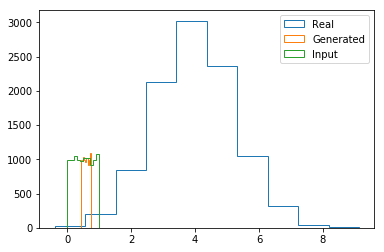

Stage 1 (Epoch:200)
Mean and Std of Real: (3.995468311164135, 1.2606199000935348)
Mean and Std of Gen: (0.26194933, 0.1572087)


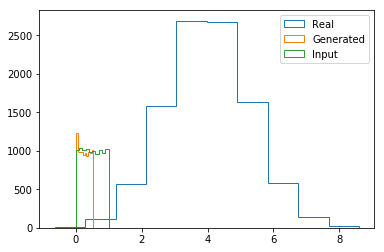

Stage 2 (Epoch:400)
Mean and Std of Real: (3.9873172075546397, 1.2504240646515972)
Mean and Std of Gen: (0.4384199, 0.37096074)


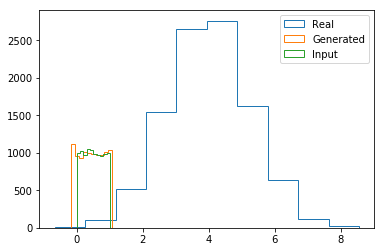

Stage 3 (Epoch:600)
Mean and Std of Real: (4.023504425506965, 1.249232706024223)
Mean and Std of Gen: (1.7261615, 0.791763)


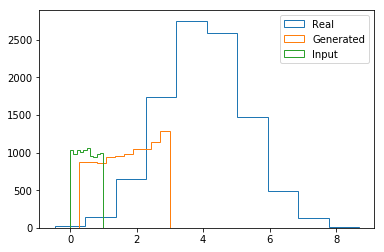

Stage 4 (Epoch:800)
Mean and Std of Real: (3.998534529173425, 1.2369996858499352)
Mean and Std of Gen: (2.742843, 1.0085979)


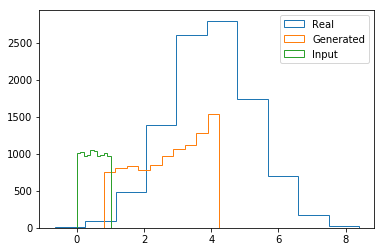

Stage 5 (Epoch:1000)
Mean and Std of Real: (3.9973090039931516, 1.254164533720429)
Mean and Std of Gen: (3.479655, 1.1402262)


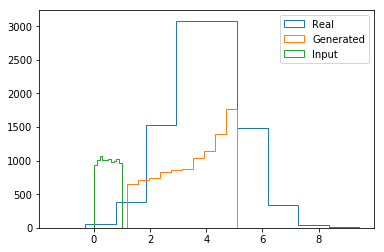

Stage 6 (Epoch:1200)
Mean and Std of Real: (3.9847013881616773, 1.2576773256291656)
Mean and Std of Gen: (3.8773837, 1.3256948)


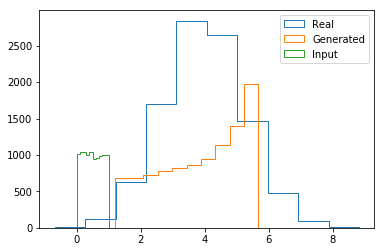

Stage 7 (Epoch:1400)
Mean and Std of Real: (4.012833977690617, 1.2500536428126616)
Mean and Std of Gen: (4.4048276, 1.4057447)


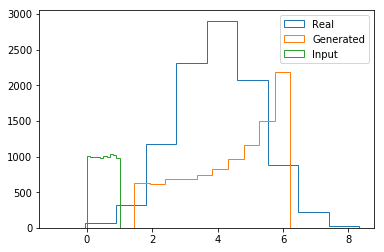

Stage 8 (Epoch:1600)
Mean and Std of Real: (4.013234403913675, 1.2510394101582458)
Mean and Std of Gen: (5.0449176, 1.3167357)


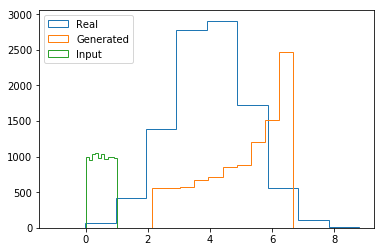

Stage 9 (Epoch:1800)
Mean and Std of Real: (4.002088089205837, 1.2566569603051219)
Mean and Std of Gen: (4.8900537, 1.4717091)


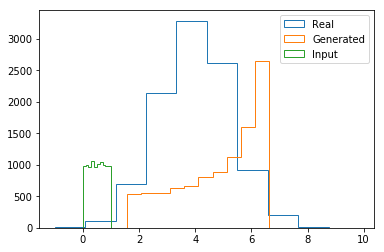

Stage 10 (Epoch:2000)
Mean and Std of Real: (3.993825281239578, 1.2486491516580487)
Mean and Std of Gen: (5.101105, 1.3928375)


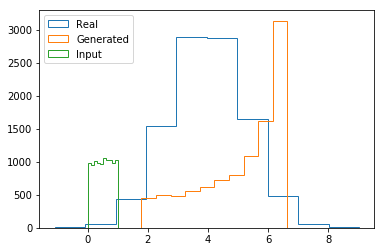

Stage 11 (Epoch:2200)
Mean and Std of Real: (3.990927403394063, 1.252225493222872)
Mean and Std of Gen: (5.0642457, 1.4540741)


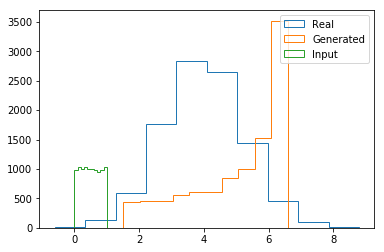

Stage 12 (Epoch:2400)
Mean and Std of Real: (4.00523324406195, 1.25099413089001)
Mean and Std of Gen: (5.36766, 1.2710366)


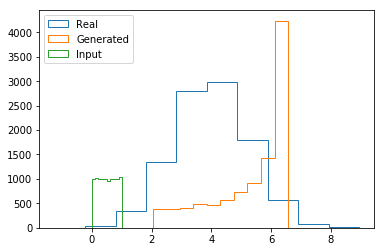

Stage 13 (Epoch:2600)
Mean and Std of Real: (3.9899991149118788, 1.23836562767057)
Mean and Std of Gen: (4.956122, 1.5304744)


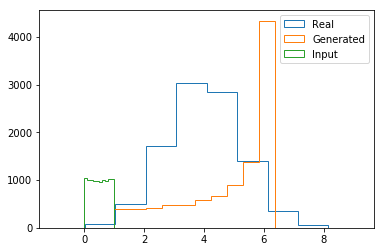

Stage 14 (Epoch:2800)
Mean and Std of Real: (3.997118259750801, 1.2573277930391231)
Mean and Std of Gen: (4.918848, 1.4561373)


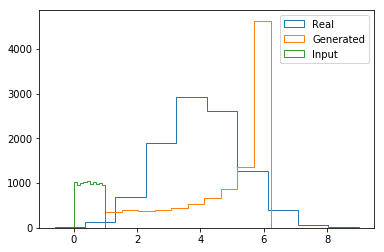

Stage 15 (Epoch:3000)
Mean and Std of Real: (3.9908489663631976, 1.236478597036996)
Mean and Std of Gen: (5.0359325, 1.321612)


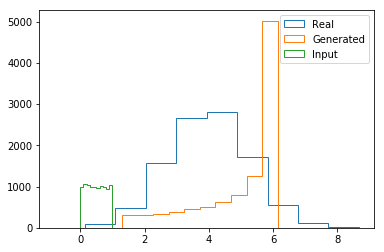

Stage 16 (Epoch:3200)
Mean and Std of Real: (3.9728129384192563, 1.2527215042916642)
Mean and Std of Gen: (4.8871846, 1.3269383)


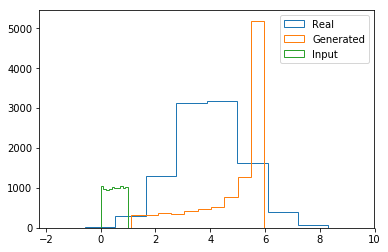

Stage 17 (Epoch:3400)
Mean and Std of Real: (3.9848251708700833, 1.2489424264889655)
Mean and Std of Gen: (4.653261, 1.3066875)


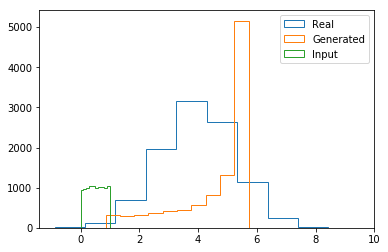

Stage 18 (Epoch:3600)
Mean and Std of Real: (3.9838949937531303, 1.249917271425761)
Mean and Std of Gen: (4.402269, 1.3036054)


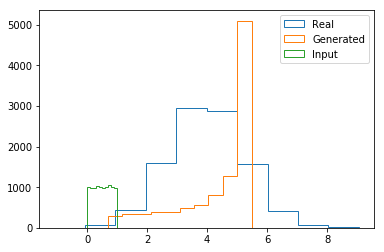

Stage 19 (Epoch:3800)
Mean and Std of Real: (3.9896572627393225, 1.258569236882378)
Mean and Std of Gen: (4.2147284, 1.28981)


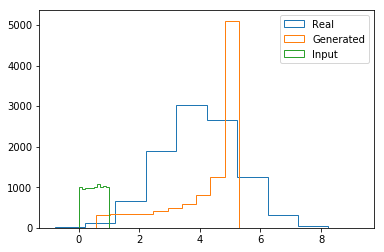

Stage 20 (Epoch:4000)
Mean and Std of Real: (3.9805949618430168, 1.2691828771333877)
Mean and Std of Gen: (4.034639, 1.2202936)


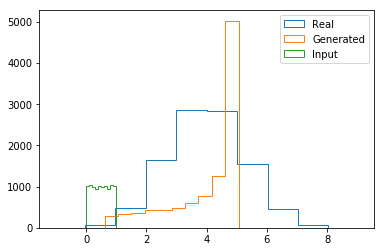

Stage 21 (Epoch:4200)
Mean and Std of Real: (4.013999072463467, 1.23732296442805)
Mean and Std of Gen: (3.8353379, 1.2096847)


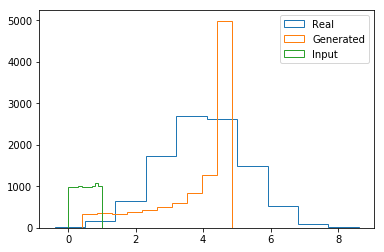

Stage 22 (Epoch:4400)
Mean and Std of Real: (4.02152346469566, 1.250086877420867)
Mean and Std of Gen: (3.7314243, 1.2452078)


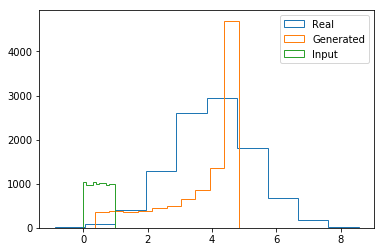

Stage 23 (Epoch:4600)
Mean and Std of Real: (3.9907285457829014, 1.2551092539937114)
Mean and Std of Gen: (3.825075, 1.2138689)


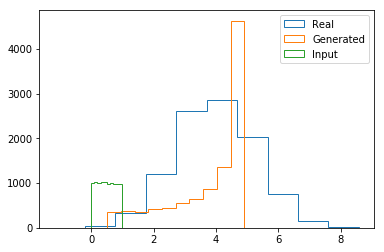

Stage 24 (Epoch:4800)
Mean and Std of Real: (3.9959671966755725, 1.2475832550268062)
Mean and Std of Gen: (3.9819274, 1.1947496)


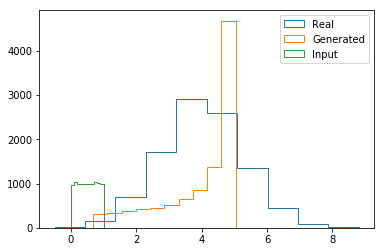

Stage 25 (Epoch:5000)
Mean and Std of Real: (4.01933762830802, 1.2621083579721764)
Mean and Std of Gen: (3.9164224, 1.2483708)


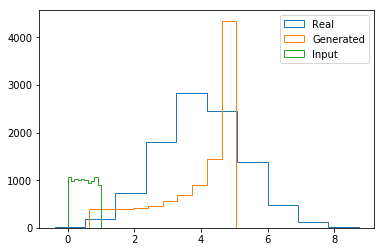

Stage 26 (Epoch:5200)
Mean and Std of Real: (3.9648219787740318, 1.2606346905595518)
Mean and Std of Gen: (4.14813, 1.2061362)


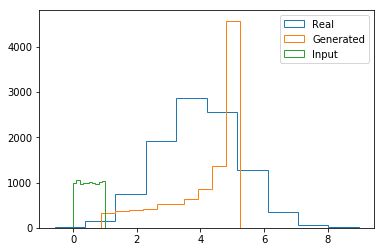

Stage 27 (Epoch:5400)
Mean and Std of Real: (3.9942561646651717, 1.2721009982633014)
Mean and Std of Gen: (3.8678875, 1.2638421)


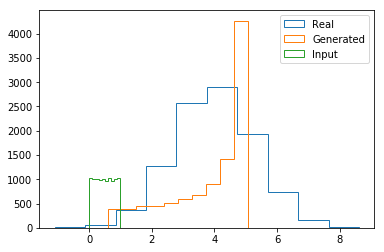

Stage 28 (Epoch:5600)
Mean and Std of Real: (3.9940512384851456, 1.2589345224622994)
Mean and Std of Gen: (4.099053, 1.1832654)


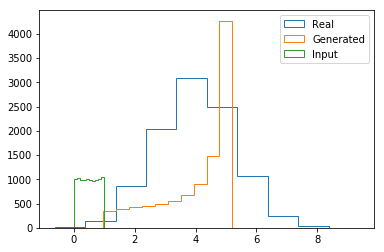

Stage 29 (Epoch:5800)
Mean and Std of Real: (4.004002509611783, 1.251877039076188)
Mean and Std of Gen: (3.7833807, 1.2817091)


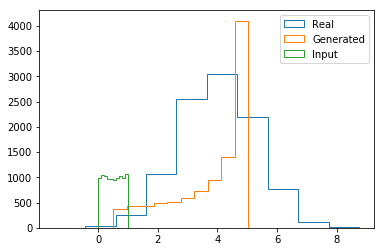

Stage 30 (Epoch:6000)
Mean and Std of Real: (4.006141112832571, 1.2518596872239642)
Mean and Std of Gen: (3.834727, 1.2786379)


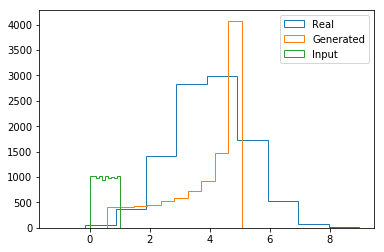

Stage 31 (Epoch:6200)
Mean and Std of Real: (4.007954471434672, 1.253297976784237)
Mean and Std of Gen: (4.080375, 1.1881033)


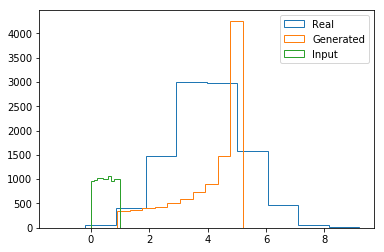

Stage 32 (Epoch:6400)
Mean and Std of Real: (3.992961224295785, 1.2618462658836094)
Mean and Std of Gen: (3.9541879, 1.2872673)


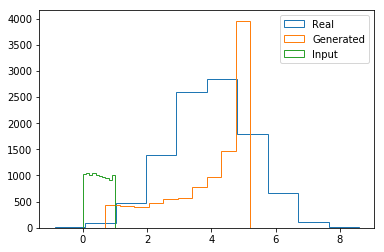

Stage 33 (Epoch:6600)
Mean and Std of Real: (3.9980454668161896, 1.2312010155417727)
Mean and Std of Gen: (4.1401978, 1.2860359)


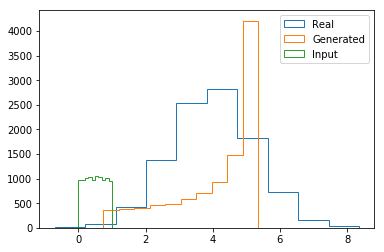

Stage 34 (Epoch:6800)
Mean and Std of Real: (3.9763327362018694, 1.2476744811856089)
Mean and Std of Gen: (4.1399097, 1.2868313)


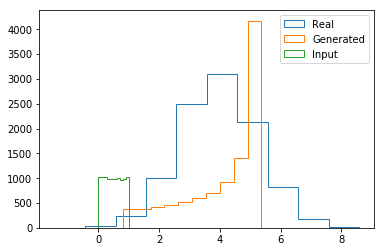

Stage 35 (Epoch:7000)
Mean and Std of Real: (4.003210803698649, 1.2627438575132797)
Mean and Std of Gen: (3.9940403, 1.2301762)


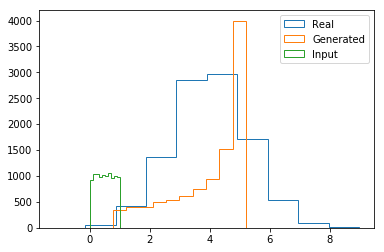

Stage 36 (Epoch:7200)
Mean and Std of Real: (4.016035106100752, 1.2515326587837368)
Mean and Std of Gen: (3.8687048, 1.2755467)


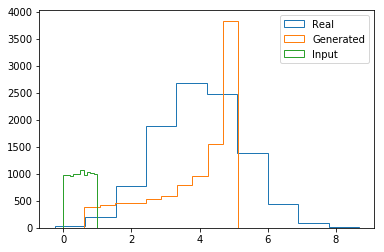

Stage 37 (Epoch:7400)
Mean and Std of Real: (4.018172006732472, 1.2510537877074714)
Mean and Std of Gen: (4.0942225, 1.1062124)


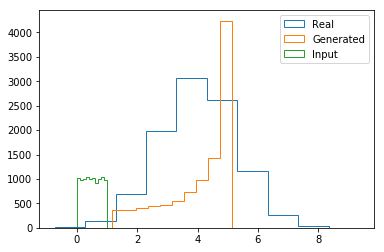

Stage 38 (Epoch:7600)
Mean and Std of Real: (4.01860288621275, 1.2396666800303964)
Mean and Std of Gen: (3.4813566, 1.309411)


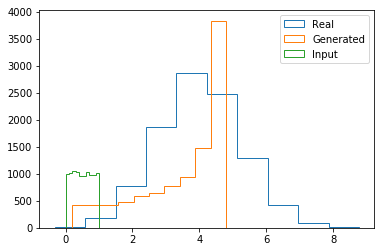

Stage 39 (Epoch:7800)
Mean and Std of Real: (3.9743210630140298, 1.2511377504858106)
Mean and Std of Gen: (4.0042076, 1.2515303)


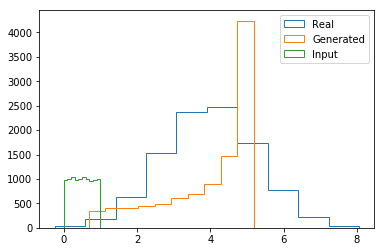

Stage 40 (Epoch:8000)
Mean and Std of Real: (4.0023630087741155, 1.2522920377820188)
Mean and Std of Gen: (4.0927987, 1.188737)


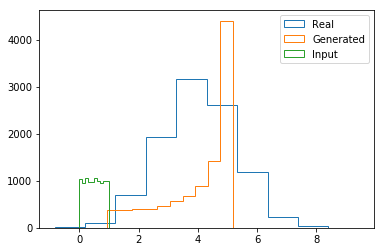

Stage 41 (Epoch:8200)
Mean and Std of Real: (3.991843322239988, 1.2424923289305585)
Mean and Std of Gen: (4.2649016, 1.1941423)


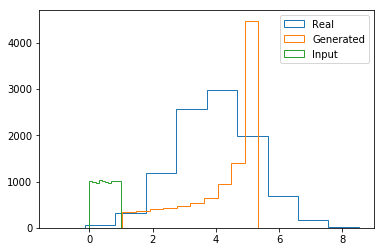

Stage 42 (Epoch:8400)
Mean and Std of Real: (3.9965915796280256, 1.257989028124341)
Mean and Std of Gen: (4.0745096, 1.2482167)


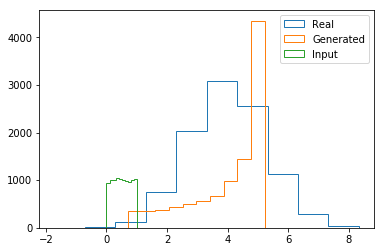

Stage 43 (Epoch:8600)
Mean and Std of Real: (4.026474183256067, 1.257840078604556)
Mean and Std of Gen: (3.8597028, 1.3363051)


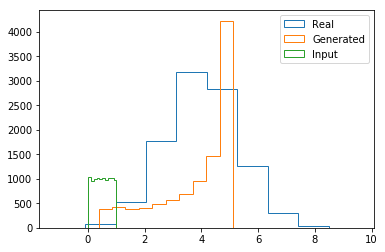

Stage 44 (Epoch:8800)
Mean and Std of Real: (4.0039863002022775, 1.2341236556415534)
Mean and Std of Gen: (4.243461, 1.2110444)


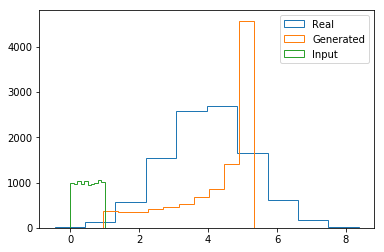

Stage 45 (Epoch:9000)
Mean and Std of Real: (3.9938742398124223, 1.256974469802523)
Mean and Std of Gen: (4.3270082, 1.2380283)


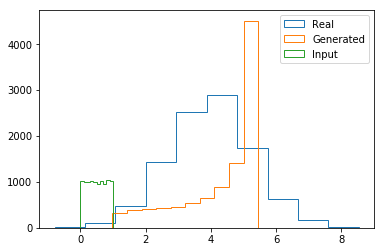

Stage 46 (Epoch:9200)
Mean and Std of Real: (3.9754085715457275, 1.258221784979486)
Mean and Std of Gen: (4.0429573, 1.2168015)


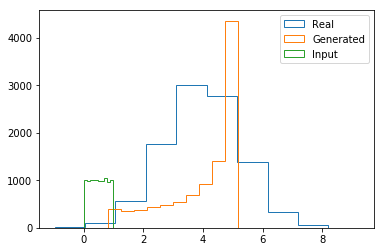

Stage 47 (Epoch:9400)
Mean and Std of Real: (4.0096911627046765, 1.2549059657215282)
Mean and Std of Gen: (3.7359574, 1.2429022)


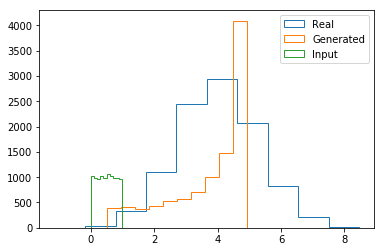

Stage 48 (Epoch:9600)
Mean and Std of Real: (4.0043077200152215, 1.2528127623382388)
Mean and Std of Gen: (3.965654, 1.2127384)


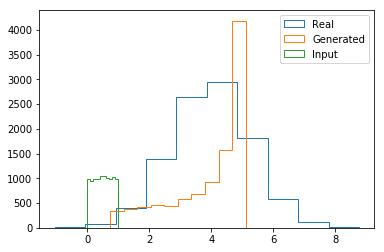

Stage 49 (Epoch:9800)
Mean and Std of Real: (4.016378715428815, 1.2424241167279204)
Mean and Std of Gen: (3.797143, 1.2825934)


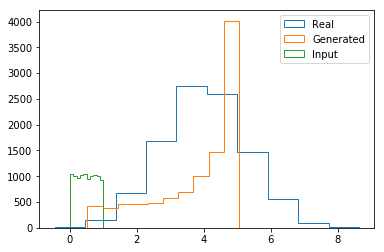

Stage 50 (Epoch:10000)
Mean and Std of Real: (4.016432173923839, 1.2598446109730819)
Mean and Std of Gen: (3.8967261, 1.284761)


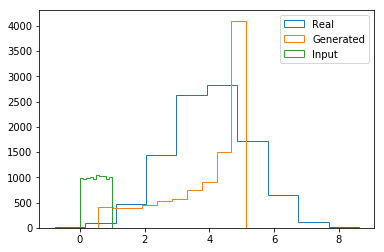

Stage 51 (Epoch:10200)
Mean and Std of Real: (4.014363276943077, 1.2388614872621015)
Mean and Std of Gen: (3.9348621, 1.1943805)


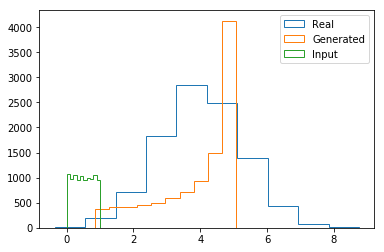

Stage 52 (Epoch:10400)
Mean and Std of Real: (3.976569330521981, 1.2534643486313273)
Mean and Std of Gen: (3.8707125, 1.1982856)


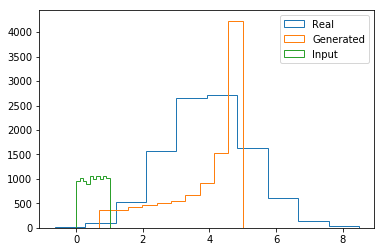

Stage 53 (Epoch:10600)
Mean and Std of Real: (4.00262749860817, 1.256124041312284)
Mean and Std of Gen: (3.8302906, 1.2789651)


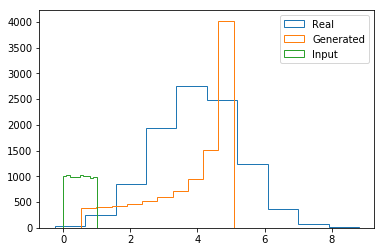

Stage 54 (Epoch:10800)
Mean and Std of Real: (4.030346285413469, 1.2531391488853056)
Mean and Std of Gen: (3.8626597, 1.2511669)


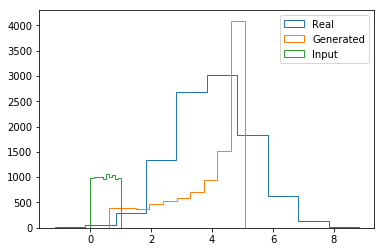

Stage 55 (Epoch:11000)
Mean and Std of Real: (4.000591659123989, 1.2600578080500393)
Mean and Std of Gen: (3.997184, 1.2743012)


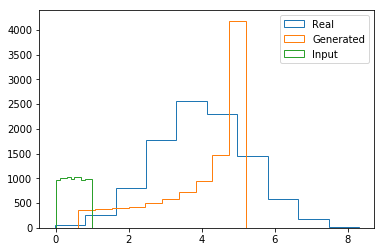

Stage 56 (Epoch:11200)
Mean and Std of Real: (4.02154978317718, 1.2485448133939239)
Mean and Std of Gen: (4.126306, 1.220897)


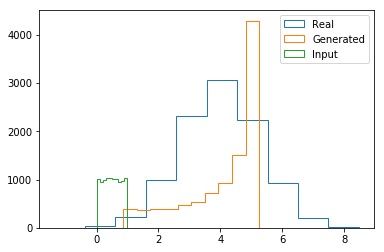

Stage 57 (Epoch:11400)
Mean and Std of Real: (4.00362952278278, 1.2273331010163282)
Mean and Std of Gen: (3.8714983, 1.3000662)


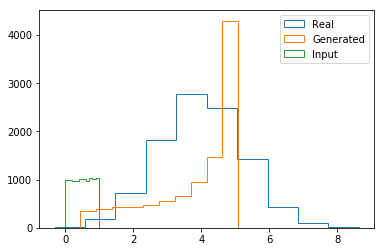

Stage 58 (Epoch:11600)
Mean and Std of Real: (4.007790621571729, 1.2417409566830113)
Mean and Std of Gen: (3.9498165, 1.2604078)


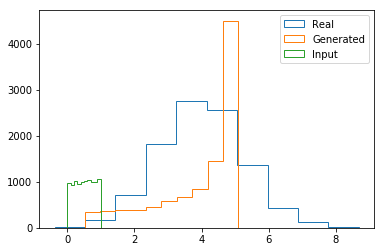

Stage 59 (Epoch:11800)
Mean and Std of Real: (4.012829707794266, 1.2541414501313424)
Mean and Std of Gen: (4.117429, 1.2068022)


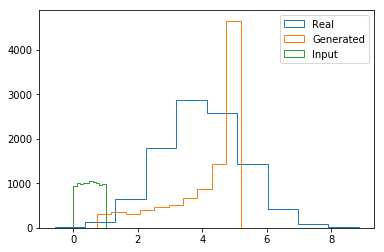

Stage 60 (Epoch:12000)
Mean and Std of Real: (4.0022285371269115, 1.262935417042269)
Mean and Std of Gen: (3.869398, 1.1591597)


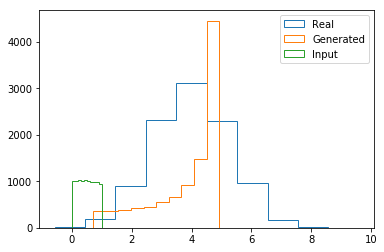

Stage 61 (Epoch:12200)
Mean and Std of Real: (4.000148179572898, 1.2488151424674852)
Mean and Std of Gen: (3.7638335, 1.20206)


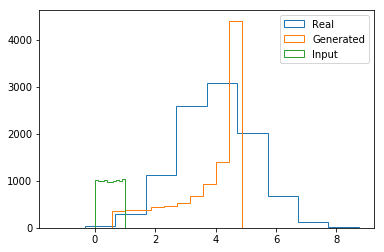

Stage 62 (Epoch:12400)
Mean and Std of Real: (3.995012557923265, 1.2527011684791347)
Mean and Std of Gen: (3.7477593, 1.246411)


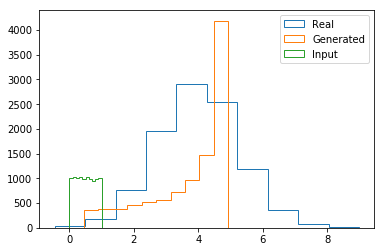

Stage 63 (Epoch:12600)
Mean and Std of Real: (4.018582695258372, 1.248324921603005)
Mean and Std of Gen: (3.9348419, 1.2758836)


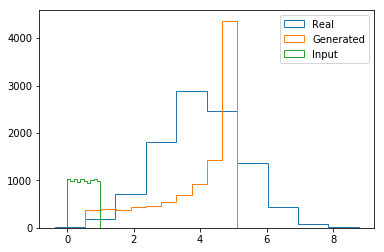

Stage 64 (Epoch:12800)
Mean and Std of Real: (3.991154897392112, 1.243800052633867)
Mean and Std of Gen: (4.072293, 1.2449932)


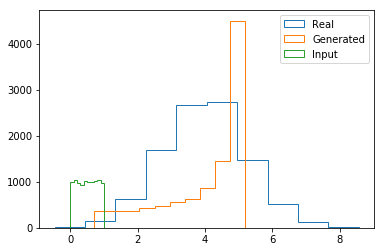

Stage 65 (Epoch:13000)
Mean and Std of Real: (4.002152596738806, 1.2616280074537676)
Mean and Std of Gen: (4.1853046, 1.2148402)


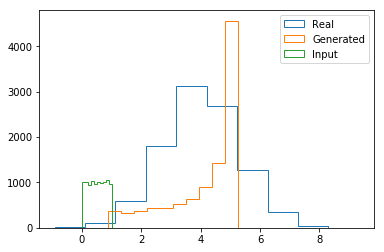

Stage 66 (Epoch:13200)
Mean and Std of Real: (3.993423003638402, 1.2485952234603992)
Mean and Std of Gen: (3.9806957, 1.3677695)


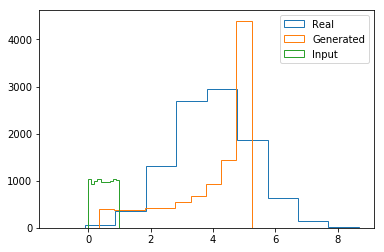

Stage 67 (Epoch:13400)
Mean and Std of Real: (3.9988671640606155, 1.2379005101282654)
Mean and Std of Gen: (4.285904, 1.2303966)


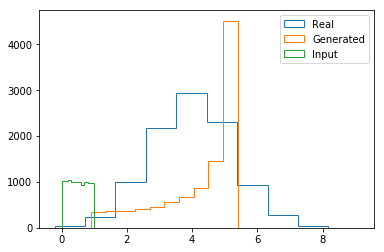

Stage 68 (Epoch:13600)
Mean and Std of Real: (4.000645509273957, 1.257644107993803)
Mean and Std of Gen: (4.1593103, 1.2865847)


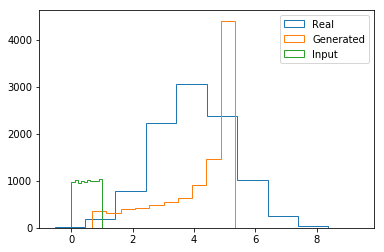

Stage 69 (Epoch:13800)
Mean and Std of Real: (3.9916087503384245, 1.2475410773140423)
Mean and Std of Gen: (4.1549163, 1.2457197)


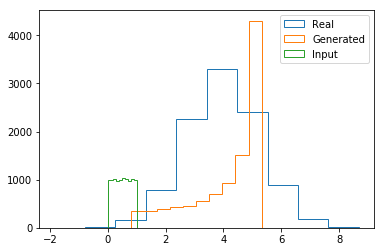

Stage 70 (Epoch:14000)
Mean and Std of Real: (4.008581934567076, 1.2493520537050389)
Mean and Std of Gen: (3.9342606, 1.2644068)


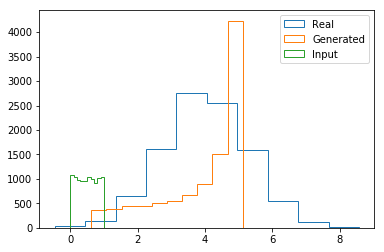

Stage 71 (Epoch:14200)
Mean and Std of Real: (3.9884494080090453, 1.2473541908671062)
Mean and Std of Gen: (3.794152, 1.1952274)


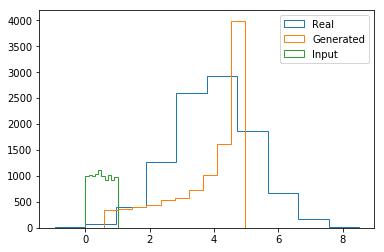

Stage 72 (Epoch:14400)
Mean and Std of Real: (3.999367530488507, 1.2440714082007465)
Mean and Std of Gen: (3.752534, 1.1799542)


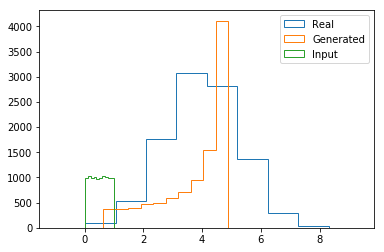

Stage 73 (Epoch:14600)
Mean and Std of Real: (3.9810313690258123, 1.251050120207837)
Mean and Std of Gen: (3.745937, 1.253548)


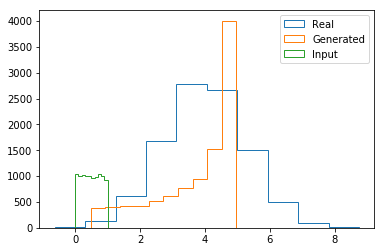

Stage 74 (Epoch:14800)
Mean and Std of Real: (4.019184420139345, 1.2511826797716903)
Mean and Std of Gen: (3.9377606, 1.2023629)


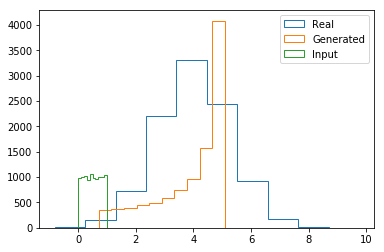

Stage 75 (Epoch:15000)
Mean and Std of Real: (3.9992680091951085, 1.2529137854076755)
Mean and Std of Gen: (3.9030738, 1.2542708)


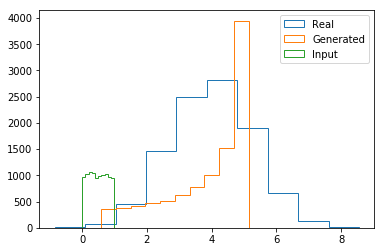

Stage 76 (Epoch:15200)
Mean and Std of Real: (3.997683399204166, 1.2476904675647187)
Mean and Std of Gen: (3.8117406, 1.3328305)


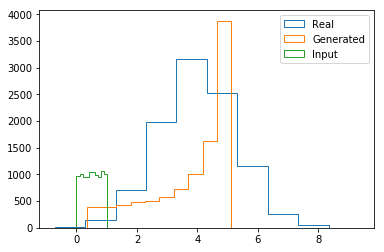

Stage 77 (Epoch:15400)
Mean and Std of Real: (4.002266393456363, 1.2552092851381265)
Mean and Std of Gen: (3.9255219, 1.2312428)


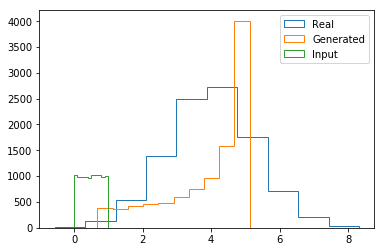

Stage 78 (Epoch:15600)
Mean and Std of Real: (4.005101935973458, 1.2474913179622618)
Mean and Std of Gen: (4.1060452, 1.1746111)


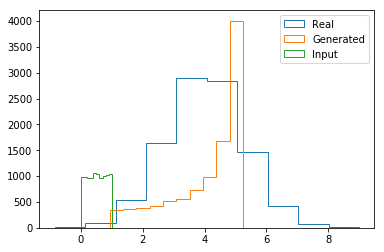

Stage 79 (Epoch:15800)
Mean and Std of Real: (4.015750560815395, 1.2454577588655034)
Mean and Std of Gen: (3.7092102, 1.2008173)


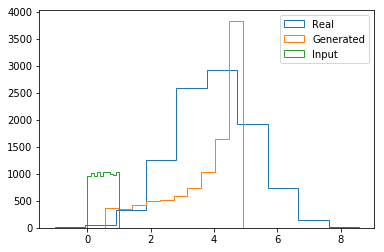

Stage 80 (Epoch:16000)
Mean and Std of Real: (4.018460990406137, 1.261569073462097)
Mean and Std of Gen: (3.7236242, 1.2102817)


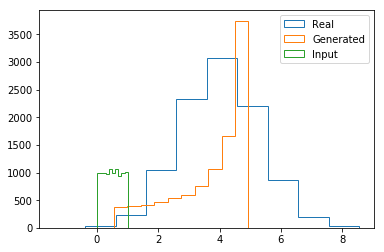

Stage 81 (Epoch:16200)
Mean and Std of Real: (3.992347789304622, 1.2429000029926673)
Mean and Std of Gen: (3.420511, 1.1791497)


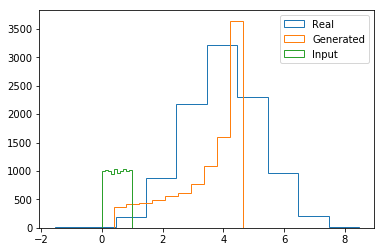

Stage 82 (Epoch:16400)
Mean and Std of Real: (4.004363043586473, 1.2504197912207344)
Mean and Std of Gen: (3.4266922, 1.1776066)


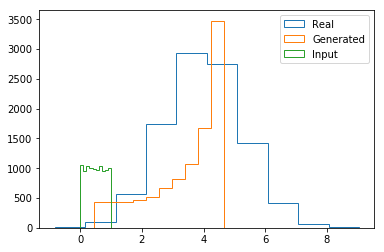

Stage 83 (Epoch:16600)
Mean and Std of Real: (4.027438397103394, 1.2443624079654079)
Mean and Std of Gen: (3.7337804, 1.1426178)


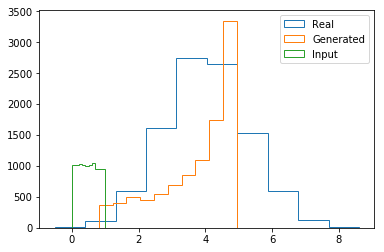

Stage 84 (Epoch:16800)
Mean and Std of Real: (3.9982399929191437, 1.2614947992320085)
Mean and Std of Gen: (3.911888, 1.1929305)


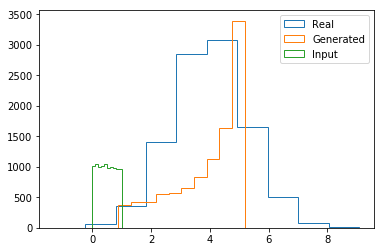

Stage 85 (Epoch:17000)
Mean and Std of Real: (3.9868072802441055, 1.2538709132490338)
Mean and Std of Gen: (3.9373548, 1.2561139)


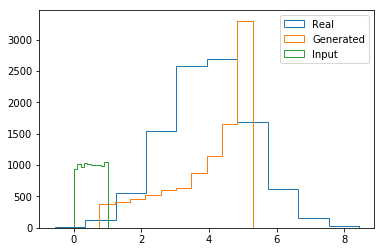

Stage 86 (Epoch:17200)
Mean and Std of Real: (3.9785603518747683, 1.2581088162982907)
Mean and Std of Gen: (3.800343, 1.285586)


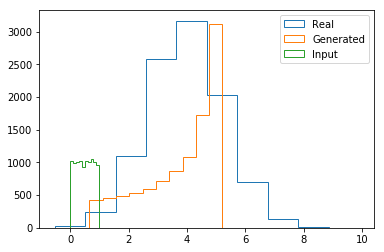

Stage 87 (Epoch:17400)
Mean and Std of Real: (3.999635312224322, 1.255313590470701)
Mean and Std of Gen: (4.068058, 1.162317)


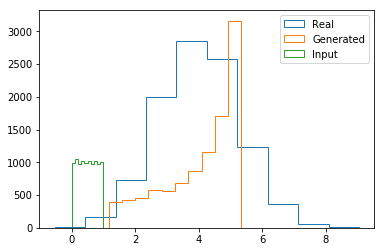

Stage 88 (Epoch:17600)
Mean and Std of Real: (3.970859802789864, 1.245357961245349)
Mean and Std of Gen: (3.4903, 1.2765987)


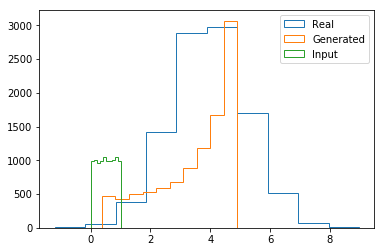

Stage 89 (Epoch:17800)
Mean and Std of Real: (3.9985341611073535, 1.250196060192426)
Mean and Std of Gen: (4.044423, 1.1103925)


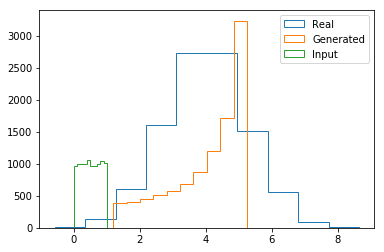

Stage 90 (Epoch:18000)
Mean and Std of Real: (3.988106843694223, 1.2369038265800016)
Mean and Std of Gen: (3.63646, 1.292936)


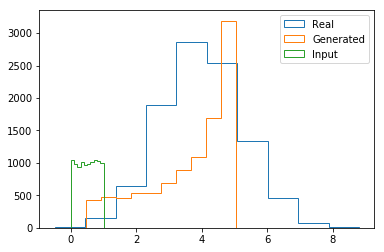

Stage 91 (Epoch:18200)
Mean and Std of Real: (4.0158850949480485, 1.2531810856627845)
Mean and Std of Gen: (4.240843, 1.1718105)


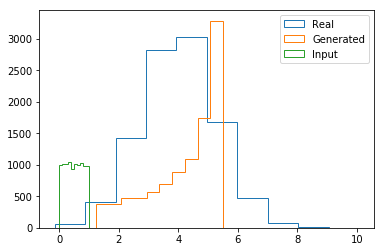

Stage 92 (Epoch:18400)
Mean and Std of Real: (3.9951672312758446, 1.2489394954290112)
Mean and Std of Gen: (3.9682753, 1.2940518)


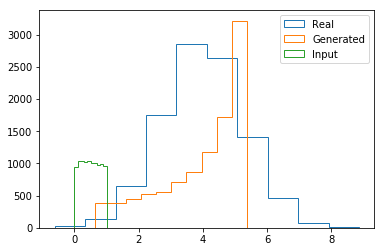

Stage 93 (Epoch:18600)
Mean and Std of Real: (4.0049396871126435, 1.235431433038829)
Mean and Std of Gen: (4.013239, 1.2409358)


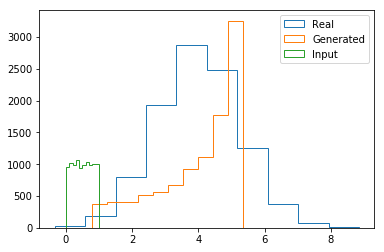

Stage 94 (Epoch:18800)
Mean and Std of Real: (4.002464682040201, 1.2316825240390838)
Mean and Std of Gen: (4.0938945, 1.2890466)


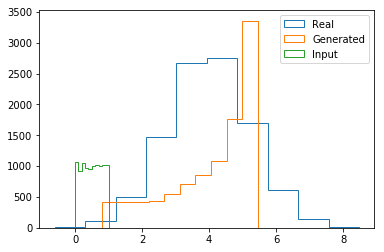

Stage 95 (Epoch:19000)
Mean and Std of Real: (3.997652872147032, 1.2425449806993738)
Mean and Std of Gen: (4.091554, 1.2862711)


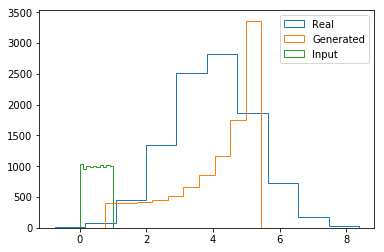

Stage 96 (Epoch:19200)
Mean and Std of Real: (4.017290781137918, 1.2608032994186789)
Mean and Std of Gen: (4.0472126, 1.226129)


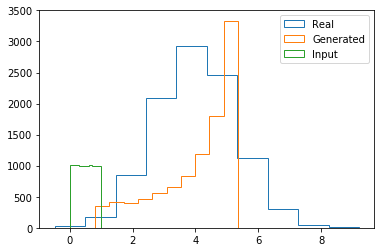

Stage 97 (Epoch:19400)
Mean and Std of Real: (3.9932519230348436, 1.2493927084613163)
Mean and Std of Gen: (4.171996, 1.242082)


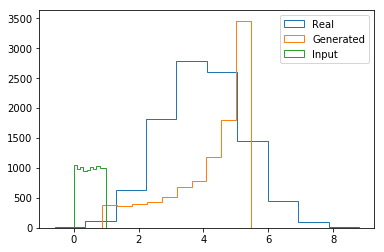

Stage 98 (Epoch:19600)
Mean and Std of Real: (3.995498563052715, 1.243505792724408)
Mean and Std of Gen: (4.01548, 1.2560703)


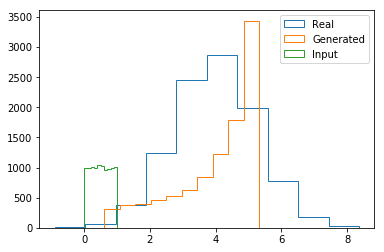

Stage 99 (Epoch:19800)
Mean and Std of Real: (4.0012194484123915, 1.2541205714724428)
Mean and Std of Gen: (3.802032, 1.278162)


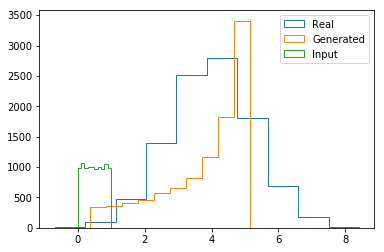

Stage 100 (Epoch:20000)
Mean and Std of Real: (4.014232475526959, 1.2418148806858709)
Mean and Std of Gen: (4.141299, 1.1555953)


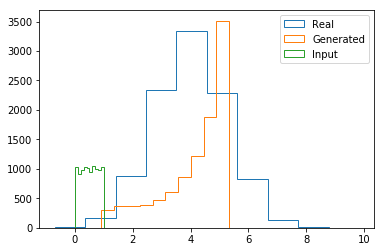

Stage 101 (Epoch:20200)
Mean and Std of Real: (3.988030531251349, 1.2458023686335948)
Mean and Std of Gen: (3.7143996, 1.3206675)


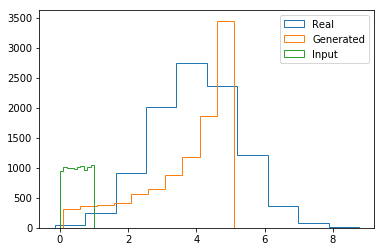

Stage 102 (Epoch:20400)
Mean and Std of Real: (4.004009350348073, 1.244269009806975)
Mean and Std of Gen: (3.987616, 1.2130309)


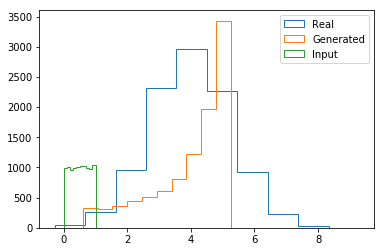

Stage 103 (Epoch:20600)
Mean and Std of Real: (3.9954454931087375, 1.2586109011061575)
Mean and Std of Gen: (3.8410554, 1.199164)


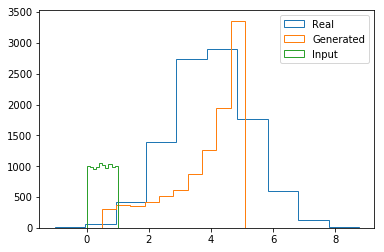

Stage 104 (Epoch:20800)
Mean and Std of Real: (4.01384322165199, 1.2482635188590538)
Mean and Std of Gen: (3.8101676, 1.2404852)


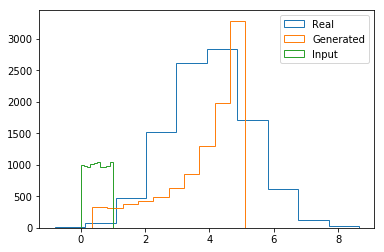

Stage 105 (Epoch:21000)
Mean and Std of Real: (3.9762001714857282, 1.2253345722243856)
Mean and Std of Gen: (3.9924157, 1.1936635)


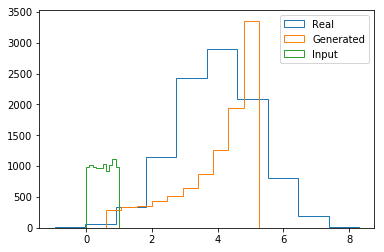

Stage 106 (Epoch:21200)
Mean and Std of Real: (4.001139176581927, 1.234869849255268)
Mean and Std of Gen: (4.078001, 1.2433212)


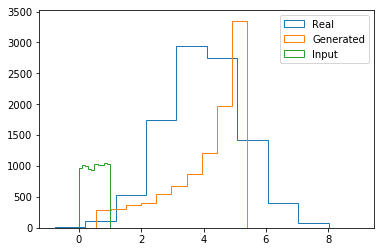

Stage 107 (Epoch:21400)
Mean and Std of Real: (4.0055541773606995, 1.2566427170317718)
Mean and Std of Gen: (3.817052, 1.2504773)


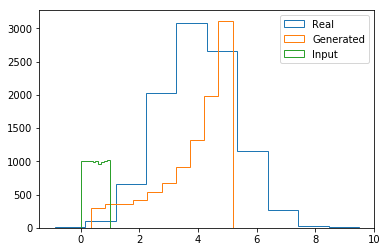

Stage 108 (Epoch:21600)
Mean and Std of Real: (4.002432945588318, 1.2519361482121714)
Mean and Std of Gen: (3.945564, 1.1612769)


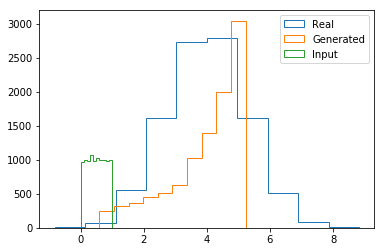

Stage 109 (Epoch:21800)
Mean and Std of Real: (3.9853587639916834, 1.2543518692704898)
Mean and Std of Gen: (3.813716, 1.2315137)


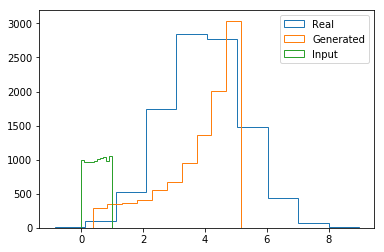

Stage 110 (Epoch:22000)
Mean and Std of Real: (4.004100477093448, 1.2689203272884844)
Mean and Std of Gen: (3.7210839, 1.2412236)


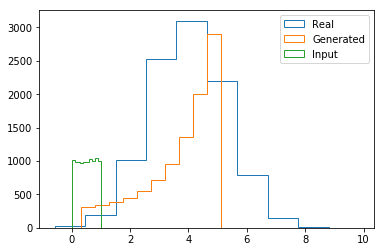

Stage 111 (Epoch:22200)
Mean and Std of Real: (4.022853452450669, 1.2640228372922409)
Mean and Std of Gen: (3.8968985, 1.2433292)


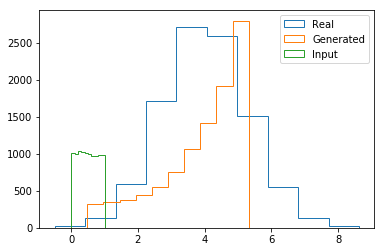

Stage 112 (Epoch:22400)
Mean and Std of Real: (3.997193291602521, 1.2509518995049047)
Mean and Std of Gen: (3.9666207, 1.238435)


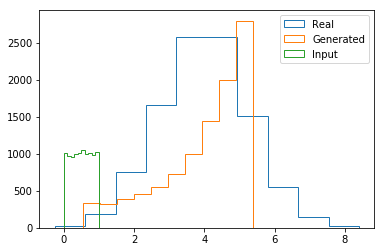

Stage 113 (Epoch:22600)
Mean and Std of Real: (3.9746787844823657, 1.2455652062623885)
Mean and Std of Gen: (3.823636, 1.2306447)


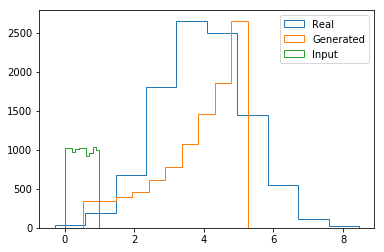

Stage 114 (Epoch:22800)
Mean and Std of Real: (4.002448079742942, 1.2621617223843944)
Mean and Std of Gen: (3.8053806, 1.17687)


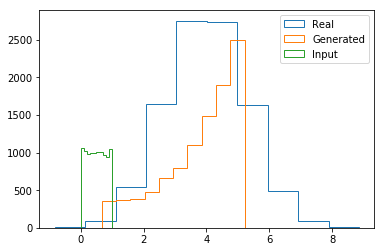

Stage 115 (Epoch:23000)
Mean and Std of Real: (4.014597908417524, 1.2630806594014796)
Mean and Std of Gen: (3.7160547, 1.272664)


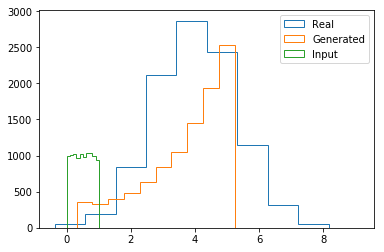

Stage 116 (Epoch:23200)
Mean and Std of Real: (3.9921716145423516, 1.261470251732898)
Mean and Std of Gen: (3.9152782, 1.2496662)


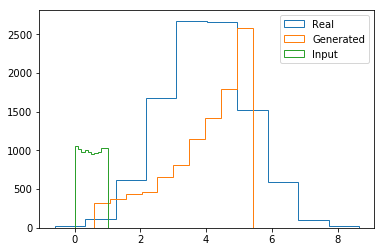

Stage 117 (Epoch:23400)
Mean and Std of Real: (3.9979839086388105, 1.2323100148911528)
Mean and Std of Gen: (3.6697683, 1.2108493)


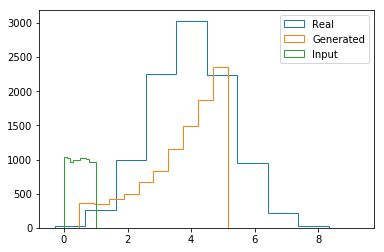

Stage 118 (Epoch:23600)
Mean and Std of Real: (3.983281666657981, 1.242328587171007)
Mean and Std of Gen: (3.6197636, 1.183865)


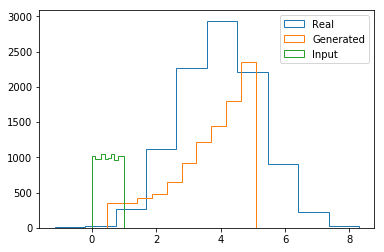

Stage 119 (Epoch:23800)
Mean and Std of Real: (4.011573489642532, 1.2606083289860914)
Mean and Std of Gen: (3.62908, 1.1666014)


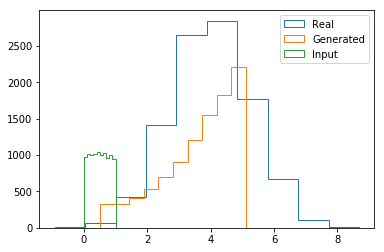

Stage 120 (Epoch:24000)
Mean and Std of Real: (3.9940381526925974, 1.2323060712835363)
Mean and Std of Gen: (3.5407696, 1.1976224)


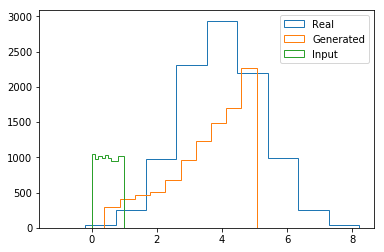

Stage 121 (Epoch:24200)
Mean and Std of Real: (3.9788699414704105, 1.258024855195549)
Mean and Std of Gen: (3.7342525, 1.1511157)


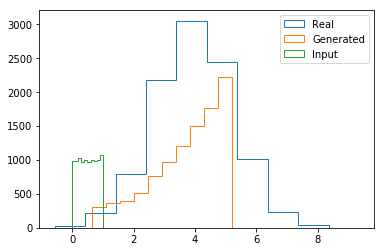

Stage 122 (Epoch:24400)
Mean and Std of Real: (4.011664659205757, 1.2573073422094463)
Mean and Std of Gen: (3.7572336, 1.0973738)


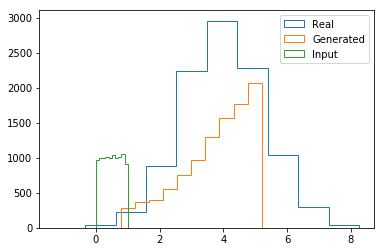

Stage 123 (Epoch:24600)
Mean and Std of Real: (3.9881240815769416, 1.2626738767285035)
Mean and Std of Gen: (3.7790534, 1.1775284)


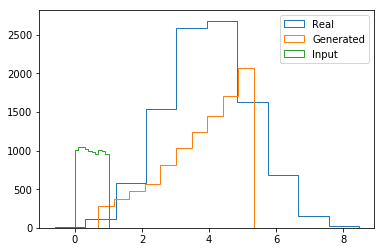

Stage 124 (Epoch:24800)
Mean and Std of Real: (4.007710558527847, 1.2550273893219313)
Mean and Std of Gen: (3.7016087, 1.1790117)


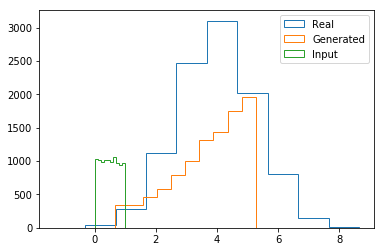

Stage 125 (Epoch:25000)
Mean and Std of Real: (3.9962352281871287, 1.2518345602213217)
Mean and Std of Gen: (3.7867782, 1.1756157)


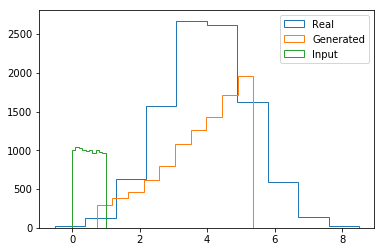

Stage 126 (Epoch:25200)
Mean and Std of Real: (3.997976893791799, 1.244739823647153)
Mean and Std of Gen: (3.8538082, 1.2493623)


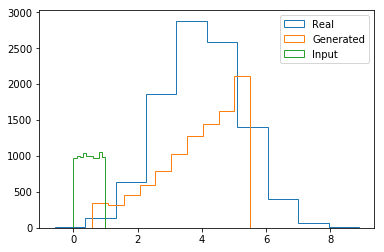

Stage 127 (Epoch:25400)
Mean and Std of Real: (4.0237194165734955, 1.2516044483768065)
Mean and Std of Gen: (3.793988, 1.2512239)


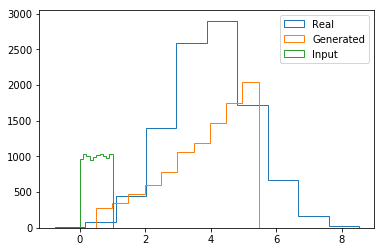

Stage 128 (Epoch:25600)
Mean and Std of Real: (4.013892625922156, 1.2462121430975115)
Mean and Std of Gen: (3.9172266, 1.219129)


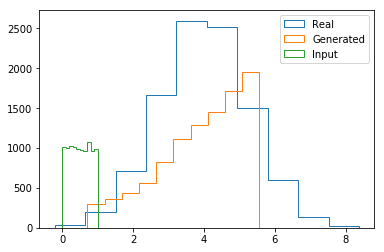

Stage 129 (Epoch:25800)
Mean and Std of Real: (4.0026026873520815, 1.2431211226854375)
Mean and Std of Gen: (3.7685304, 1.1570243)


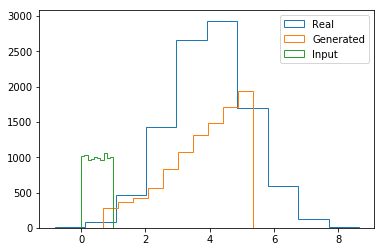

Stage 130 (Epoch:26000)
Mean and Std of Real: (4.014098851661702, 1.2522295491641129)
Mean and Std of Gen: (3.782007, 1.2775888)


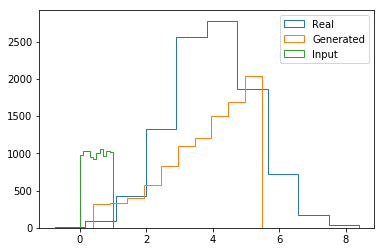

Stage 131 (Epoch:26200)
Mean and Std of Real: (4.019160693003238, 1.245354458620056)
Mean and Std of Gen: (3.7720828, 1.2544243)


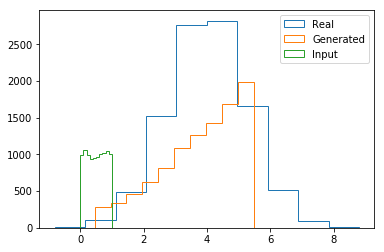

Stage 132 (Epoch:26400)
Mean and Std of Real: (4.007748591464706, 1.2539428791714924)
Mean and Std of Gen: (3.7230566, 1.1762831)


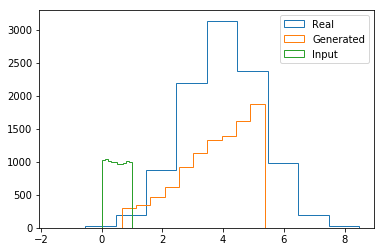

Stage 133 (Epoch:26600)
Mean and Std of Real: (3.975358936235412, 1.2547028701314658)
Mean and Std of Gen: (3.7809544, 1.2599312)


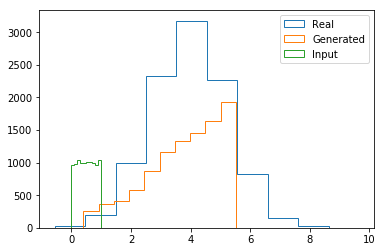

Stage 134 (Epoch:26800)
Mean and Std of Real: (4.002456177799337, 1.2528071698457326)
Mean and Std of Gen: (3.7795281, 1.2276481)


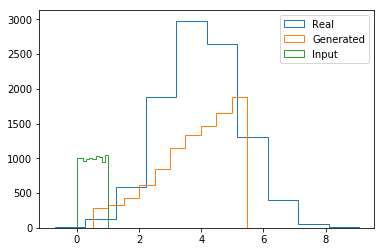

Stage 135 (Epoch:27000)
Mean and Std of Real: (3.995554696624299, 1.2635809008547112)
Mean and Std of Gen: (3.924323, 1.2375195)


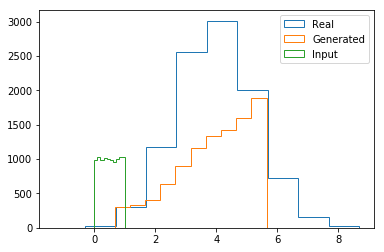

Stage 136 (Epoch:27200)
Mean and Std of Real: (3.9933772234509064, 1.25517768233316)
Mean and Std of Gen: (3.8237622, 1.2593368)


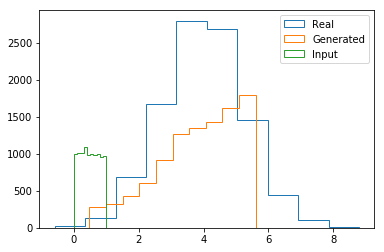

Stage 137 (Epoch:27400)
Mean and Std of Real: (4.020745601767379, 1.2493473264398964)
Mean and Std of Gen: (3.8357918, 1.2130104)


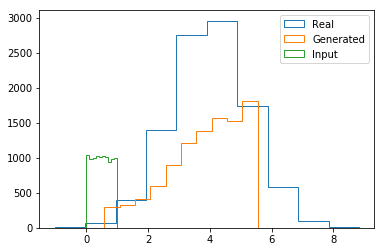

Stage 138 (Epoch:27600)
Mean and Std of Real: (4.000658061888486, 1.2498375040987513)
Mean and Std of Gen: (3.9210532, 1.2244325)


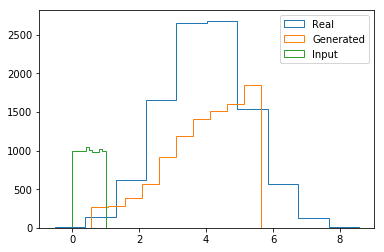

Stage 139 (Epoch:27800)
Mean and Std of Real: (3.982348087068981, 1.2440255655475423)
Mean and Std of Gen: (3.9713323, 1.2427245)


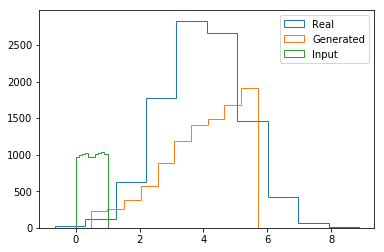

Stage 140 (Epoch:28000)
Mean and Std of Real: (3.968223961216709, 1.2586655364454744)
Mean and Std of Gen: (4.0623193, 1.222091)


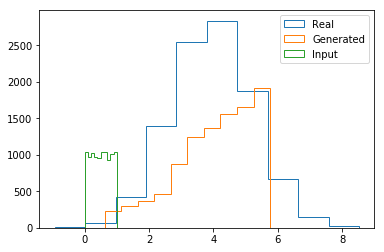

Stage 141 (Epoch:28200)
Mean and Std of Real: (4.014983769284899, 1.2530594234597017)
Mean and Std of Gen: (4.058335, 1.2192359)


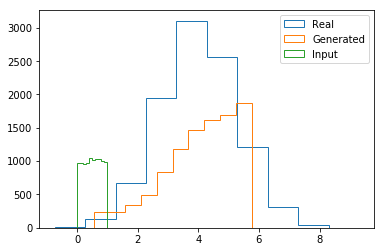

Stage 142 (Epoch:28400)
Mean and Std of Real: (4.007737566084524, 1.2508194226809777)
Mean and Std of Gen: (4.19643, 1.2603531)


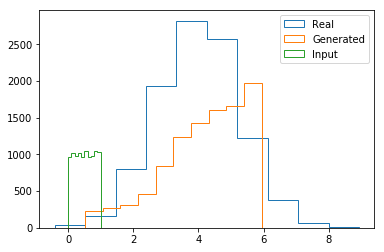

Stage 143 (Epoch:28600)
Mean and Std of Real: (4.017978808916938, 1.2367100153218078)
Mean and Std of Gen: (4.385605, 1.3198836)


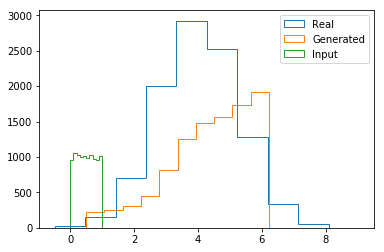

Stage 144 (Epoch:28800)
Mean and Std of Real: (3.9973224670975536, 1.2429946963825655)
Mean and Std of Gen: (4.4032545, 1.2567637)


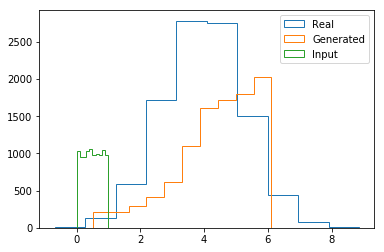

Stage 145 (Epoch:29000)
Mean and Std of Real: (4.016532962226542, 1.251952545924301)
Mean and Std of Gen: (4.505913, 1.3486775)


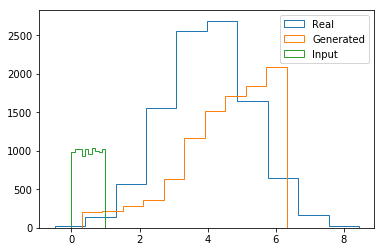

Stage 146 (Epoch:29200)
Mean and Std of Real: (4.034805203230281, 1.2488124158783032)
Mean and Std of Gen: (4.7791696, 1.3748449)


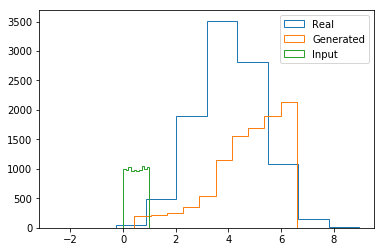

Stage 147 (Epoch:29400)
Mean and Std of Real: (3.995811911649083, 1.2509576377322165)
Mean and Std of Gen: (4.8317547, 1.3144779)


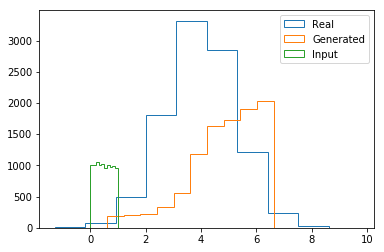

Stage 148 (Epoch:29600)
Mean and Std of Real: (4.001630548257472, 1.24692410864596)
Mean and Std of Gen: (4.948038, 1.3881674)


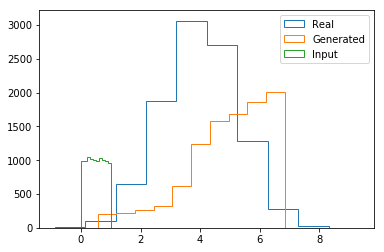

Stage 149 (Epoch:29800)
Mean and Std of Real: (4.007820527416498, 1.2465969815137299)
Mean and Std of Gen: (4.964453, 1.3955456)


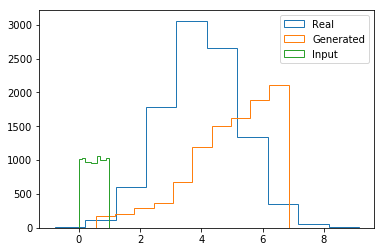

Stage 150 (Epoch:30000)
Mean and Std of Real: (4.0008277833138, 1.2460302730338253)
Mean and Std of Gen: (4.84356, 1.3754696)


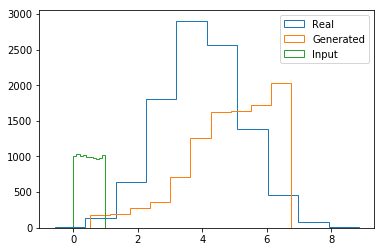

Stage 151 (Epoch:30200)
Mean and Std of Real: (3.962661767779049, 1.2395480943477661)
Mean and Std of Gen: (4.653942, 1.339981)


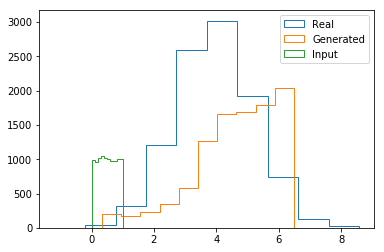

Stage 152 (Epoch:30400)
Mean and Std of Real: (4.007275517029754, 1.2531419843970888)
Mean and Std of Gen: (4.5281067, 1.2574815)


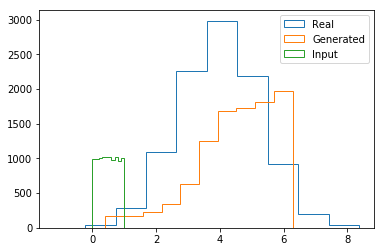

Stage 153 (Epoch:30600)
Mean and Std of Real: (4.009079337216521, 1.245266806690484)
Mean and Std of Gen: (4.5488944, 1.222329)


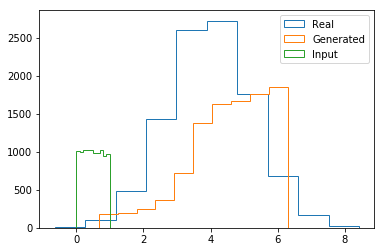

Stage 154 (Epoch:30800)
Mean and Std of Real: (4.015040182409343, 1.238554218211583)
Mean and Std of Gen: (4.4584475, 1.2934079)


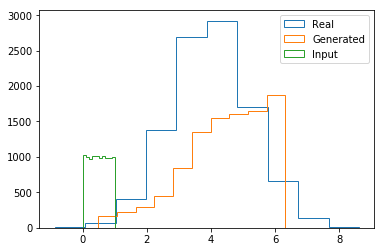

Stage 155 (Epoch:31000)
Mean and Std of Real: (3.997976256274597, 1.254589004923535)
Mean and Std of Gen: (4.172069, 1.2518169)


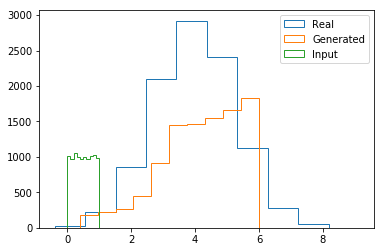

Stage 156 (Epoch:31200)
Mean and Std of Real: (3.9789547995757863, 1.260255015970802)
Mean and Std of Gen: (3.8000567, 1.207523)


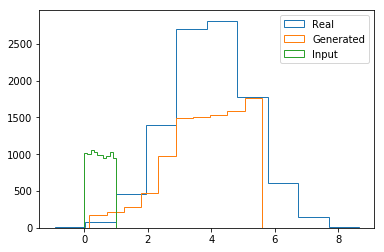

Stage 157 (Epoch:31400)
Mean and Std of Real: (4.004364860132258, 1.2529894761526303)
Mean and Std of Gen: (3.6485164, 1.1915668)


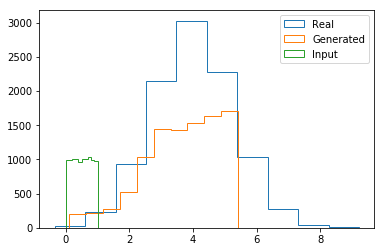

Stage 158 (Epoch:31600)
Mean and Std of Real: (4.013371116544187, 1.2653583672178161)
Mean and Std of Gen: (3.4431899, 1.1467842)


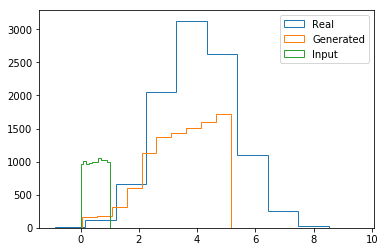

Stage 159 (Epoch:31800)
Mean and Std of Real: (4.02043926240344, 1.255280309034843)
Mean and Std of Gen: (3.3590078, 1.1539667)


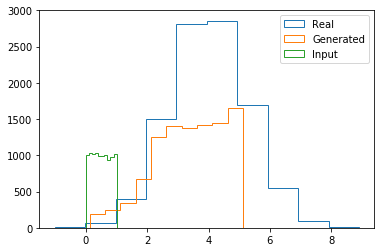

Stage 160 (Epoch:32000)
Mean and Std of Real: (3.990491390338172, 1.251511866031798)
Mean and Std of Gen: (3.220241, 1.1981351)


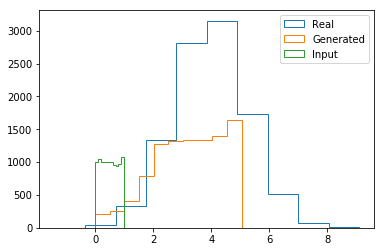

Stage 161 (Epoch:32200)
Mean and Std of Real: (3.993826876873304, 1.245957662282994)
Mean and Std of Gen: (3.2860253, 1.1680353)


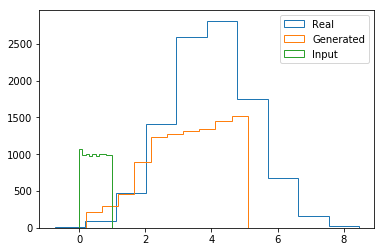

Stage 162 (Epoch:32400)
Mean and Std of Real: (3.9951731658914955, 1.2319819176549065)
Mean and Std of Gen: (3.438064, 1.1421614)


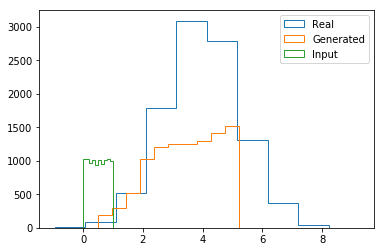

Stage 163 (Epoch:32600)
Mean and Std of Real: (4.01243823472201, 1.241798668309807)
Mean and Std of Gen: (3.3690753, 1.1286179)


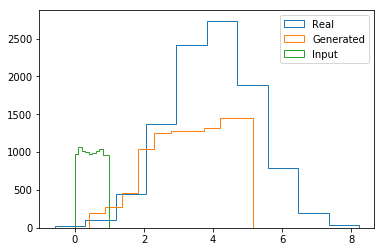

Stage 164 (Epoch:32800)
Mean and Std of Real: (3.9705001866636267, 1.2545963984092452)
Mean and Std of Gen: (3.166351, 1.1173166)


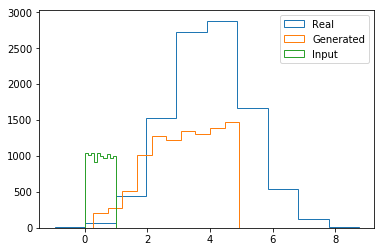

Stage 165 (Epoch:33000)
Mean and Std of Real: (4.009436587304065, 1.2664147692522059)
Mean and Std of Gen: (3.1963718, 1.2133873)


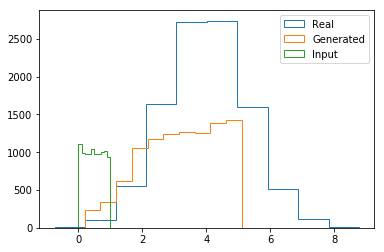

Stage 166 (Epoch:33200)
Mean and Std of Real: (3.9946757889941233, 1.2461894494196013)
Mean and Std of Gen: (3.4420016, 1.1875714)


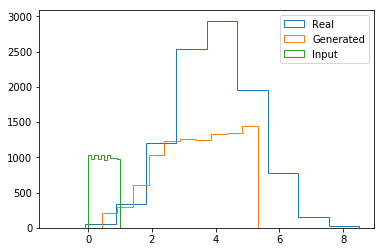

Stage 167 (Epoch:33400)
Mean and Std of Real: (3.9898394543692484, 1.261873864093895)
Mean and Std of Gen: (3.7074492, 1.2183704)


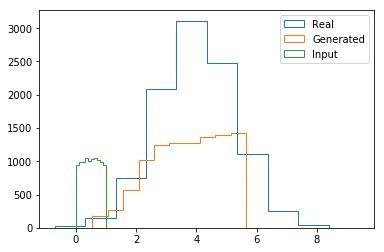

Stage 168 (Epoch:33600)
Mean and Std of Real: (3.996761323266301, 1.2613736665218875)
Mean and Std of Gen: (3.6844985, 1.1602787)


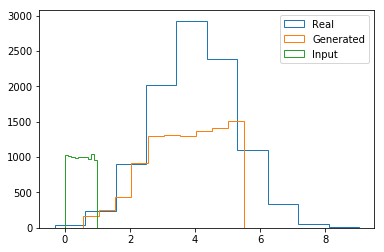

Stage 169 (Epoch:33800)
Mean and Std of Real: (4.006476259999092, 1.258014230259957)
Mean and Std of Gen: (3.6546495, 1.2094839)


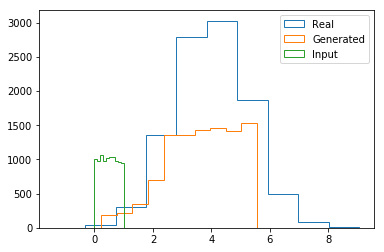

Stage 170 (Epoch:34000)
Mean and Std of Real: (4.00229105461581, 1.2589564798306674)
Mean and Std of Gen: (3.805037, 1.1773671)


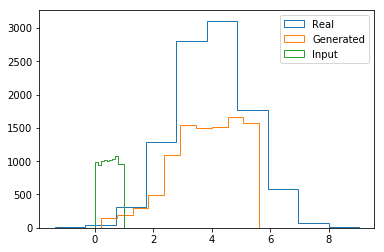

Stage 171 (Epoch:34200)
Mean and Std of Real: (3.997104011357724, 1.250833705461987)
Mean and Std of Gen: (4.0349092, 1.3040079)


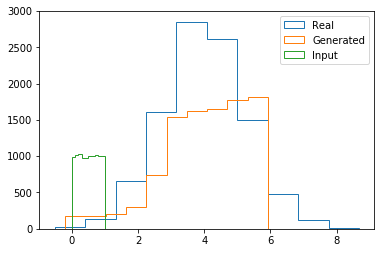

Stage 172 (Epoch:34400)
Mean and Std of Real: (4.005817819291176, 1.2415717075720387)
Mean and Std of Gen: (4.4243984, 1.3529809)


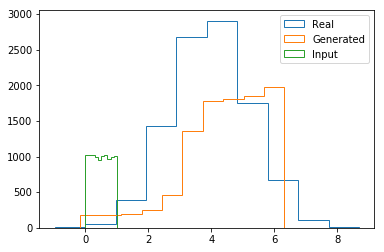

Stage 173 (Epoch:34600)
Mean and Std of Real: (4.010606157847532, 1.27093686652095)
Mean and Std of Gen: (5.0145397, 1.348919)


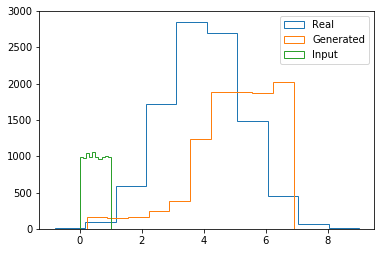

Stage 174 (Epoch:34800)
Mean and Std of Real: (3.996637056366149, 1.258798221082655)
Mean and Std of Gen: (5.3326936, 1.3162678)


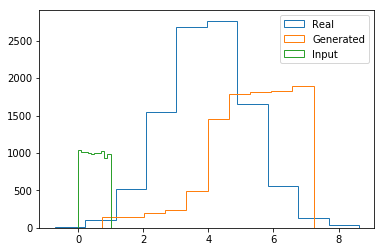

Stage 175 (Epoch:35000)
Mean and Std of Real: (3.984799016718501, 1.2506431380318868)
Mean and Std of Gen: (5.6726985, 1.4891133)


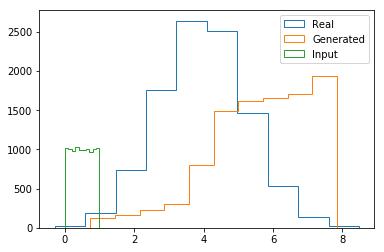

Stage 176 (Epoch:35200)
Mean and Std of Real: (4.023152094703159, 1.2544829870875116)
Mean and Std of Gen: (5.648938, 1.3919301)


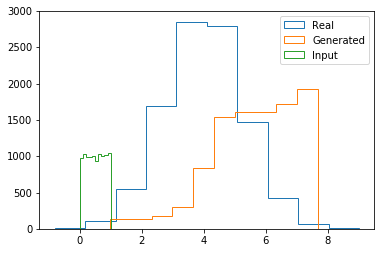

Stage 177 (Epoch:35400)
Mean and Std of Real: (4.013239212651981, 1.2441949103271643)
Mean and Std of Gen: (5.5581737, 1.4380326)


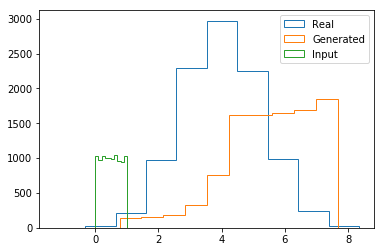

Stage 178 (Epoch:35600)
Mean and Std of Real: (4.014319472888254, 1.2366841316644763)
Mean and Std of Gen: (5.309403, 1.4873272)


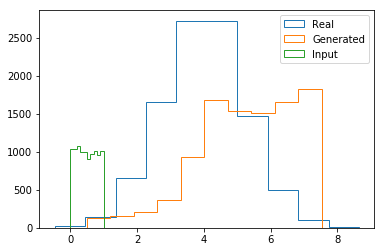

Stage 179 (Epoch:35800)
Mean and Std of Real: (3.996351834184912, 1.256488112389244)
Mean and Std of Gen: (4.902707, 1.3058589)


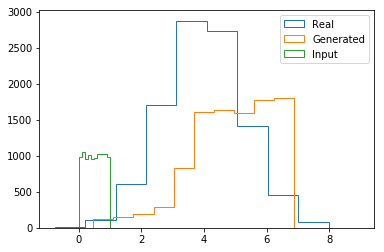

Stage 180 (Epoch:36000)
Mean and Std of Real: (3.9991244398762196, 1.2332486972344539)
Mean and Std of Gen: (4.5864367, 1.3374321)


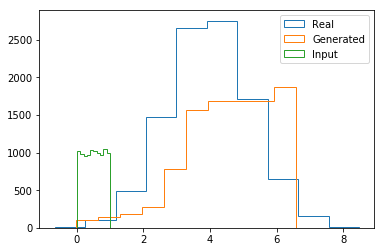

Stage 181 (Epoch:36200)
Mean and Std of Real: (4.018245854099632, 1.2484508768941853)
Mean and Std of Gen: (4.340625, 1.236441)


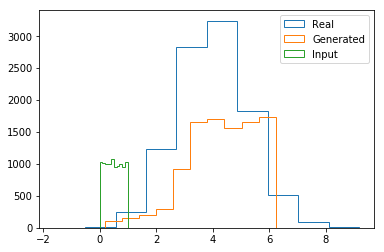

Stage 182 (Epoch:36400)
Mean and Std of Real: (4.004916271432011, 1.2575196781459048)
Mean and Std of Gen: (4.1019907, 1.2410984)


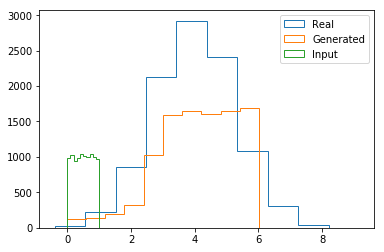

Stage 183 (Epoch:36600)
Mean and Std of Real: (4.007492716848557, 1.2438353752620015)
Mean and Std of Gen: (3.822096, 1.1545041)


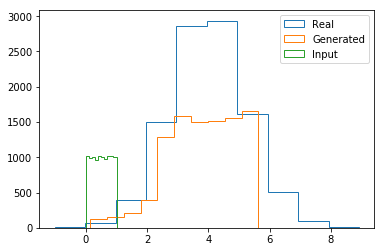

Stage 184 (Epoch:36800)
Mean and Std of Real: (4.006862134387877, 1.255420499307438)
Mean and Std of Gen: (3.6396399, 1.1916595)


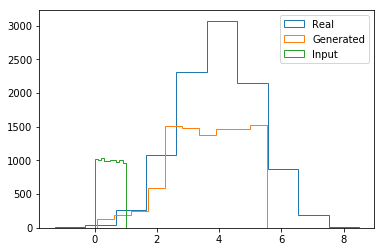

Stage 185 (Epoch:37000)
Mean and Std of Real: (4.020670608876931, 1.2391016709764593)
Mean and Std of Gen: (3.4984667, 1.208285)


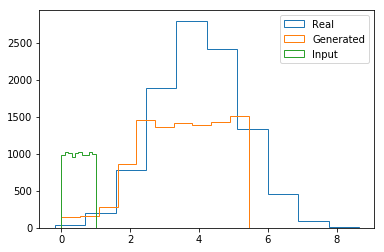

Stage 186 (Epoch:37200)
Mean and Std of Real: (4.019813057694961, 1.2507192812882097)
Mean and Std of Gen: (3.3365297, 1.2342067)


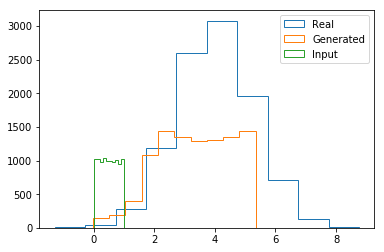

Stage 187 (Epoch:37400)
Mean and Std of Real: (4.005847693333846, 1.2557751872255367)
Mean and Std of Gen: (3.3216867, 1.1281826)


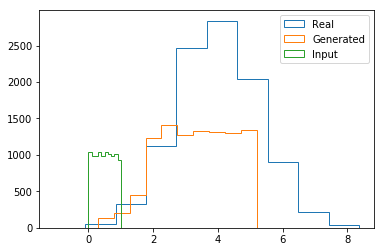

Stage 188 (Epoch:37600)
Mean and Std of Real: (3.9965964678054164, 1.2556281097150321)
Mean and Std of Gen: (3.0428095, 1.0738701)


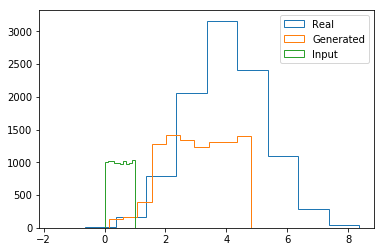

Stage 189 (Epoch:37800)
Mean and Std of Real: (4.016577138665338, 1.2477985638667812)
Mean and Std of Gen: (3.1790693, 1.1223242)


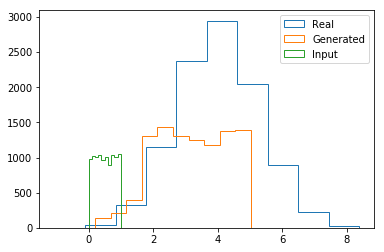

Stage 190 (Epoch:38000)
Mean and Std of Real: (3.9799851254043346, 1.2473849552708993)
Mean and Std of Gen: (3.1865058, 1.1502227)


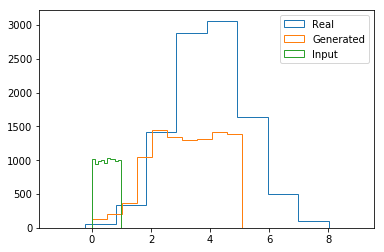

Stage 191 (Epoch:38200)
Mean and Std of Real: (4.017680154039037, 1.2513664579629853)
Mean and Std of Gen: (3.5726993, 1.1614504)


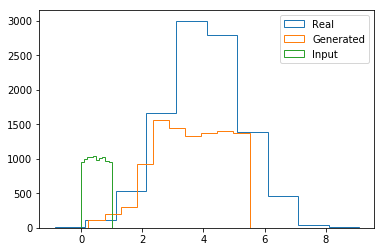

Stage 192 (Epoch:38400)
Mean and Std of Real: (3.980023531755059, 1.2483849227126265)
Mean and Std of Gen: (3.856939, 1.2879514)


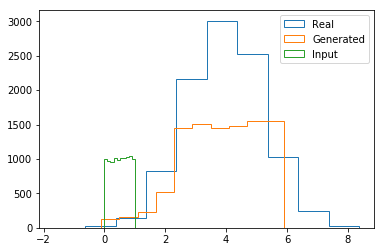

Stage 193 (Epoch:38600)
Mean and Std of Real: (3.9789138304464347, 1.2430411727516701)
Mean and Std of Gen: (4.05342, 1.2828563)


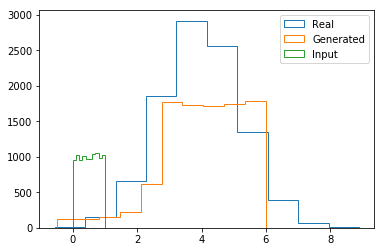

Stage 194 (Epoch:38800)
Mean and Std of Real: (3.9881600820580205, 1.2438073745886509)
Mean and Std of Gen: (4.578355, 1.4174339)


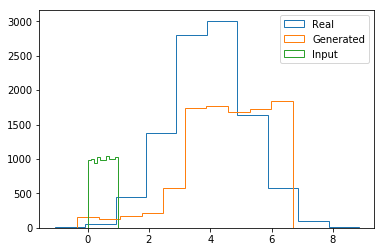

Stage 195 (Epoch:39000)
Mean and Std of Real: (3.9988299000138103, 1.2551534510537743)
Mean and Std of Gen: (5.093196, 1.4197059)


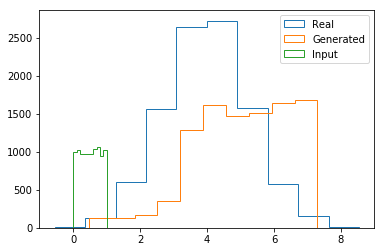

Stage 196 (Epoch:39200)
Mean and Std of Real: (4.011605010545648, 1.2640597988391056)
Mean and Std of Gen: (4.8108697, 1.2991096)


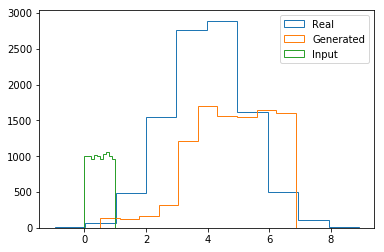

Stage 197 (Epoch:39400)
Mean and Std of Real: (3.999282617295428, 1.2590577749015208)
Mean and Std of Gen: (4.565606, 1.2573932)


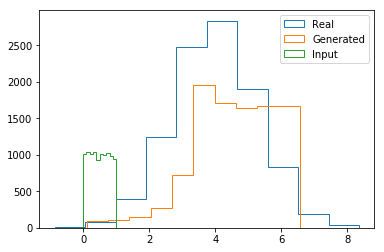

Stage 198 (Epoch:39600)
Mean and Std of Real: (4.0063781589069, 1.2499001964196876)
Mean and Std of Gen: (4.677939, 1.3600241)


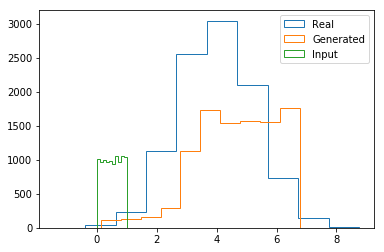

Stage 199 (Epoch:39800)
Mean and Std of Real: (4.026324792954745, 1.2595340744986048)
Mean and Std of Gen: (4.616568, 1.3517429)


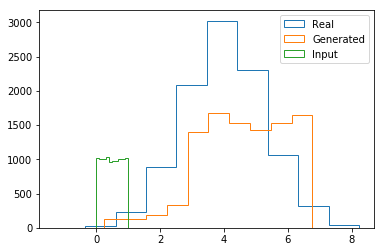

In [59]:
machine = Machine(n_batch =1 ,ni_D =100)
machine.run(n_repeat=200 ,n_show =200 ,n_test=100)